# ColNetraEmbed Inference Demo

**🚀 Universal Multilingual Multimodal Document Retrieval**

This notebook provides code for inferencing **ColNetraEmbed**, a multi-vector embedding model with late interaction for high-quality retrieval with MaxSim scoring and attention heatmaps.

**Links:**
- 📄 [Paper](https://arxiv.org/abs/2512.03514)
- 💻 [GitHub](https://github.com/adithya-s-k/colpali)
- 🤗 [HuggingFace Model](https://huggingface.co/Cognitive-Lab/ColNetraEmbed)
- 📝 [Blog](https://www.cognitivelab.in/blog/introducing-netraembed)

---

**⚠️ IMPORTANT: Set Runtime to GPU (L4 or A100 recommended, can run on T4 with smaller batch sizes)**

Go to `Runtime` → `Change runtime type` → Select `T4 GPU`, `L4 GPU` or `A100 GPU`

## 1. Install Dependencies

In [1]:
# Install required packages
!uv pip install --system git+https://github.com/adithya-s-k/colpali.git
!uv pip install --system pdf2image Pillow requests matplotlib seaborn einops numpy
!apt-get install -y poppler-utils  # For PDF to image conversion

print("✅ Installation complete!")

Using Python 3.12.12 environment at: /usr
Resolved 47 packages in 4.10s
Prepared 17 packages in 42.60s
Uninstalled 16 packages in 773ms
Installed 17 packages in 229ms
 + colpali-engine==0.1.dev261+g89d0ddf4c (from git+https://github.com/adithya-s-k/colpali.git@89d0ddf4cbc1e2e571e7e383d3fa3d99217caa69)
 - nvidia-cublas-cu12==12.6.4.1
 + nvidia-cublas-cu12==12.8.4.1
 - nvidia-cuda-cupti-cu12==12.6.80
 + nvidia-cuda-cupti-cu12==12.8.90
 - nvidia-cuda-nvrtc-cu12==12.6.77
 + nvidia-cuda-nvrtc-cu12==12.8.93
 - nvidia-cuda-runtime-cu12==12.6.77
 + nvidia-cuda-runtime-cu12==12.8.90
 - nvidia-cufft-cu12==11.3.0.4
 + nvidia-cufft-cu12==11.3.3.83
 - nvidia-cufile-cu12==1.11.1.6
 + nvidia-cufile-cu12==1.13.1.3
 - nvidia-curand-cu12==10.3.7.77
 + nvidia-curand-cu12==10.3.9.90
 - nvidia-cusolver-cu12==11.7.1.2
 + nvidia-cusolver-cu12==11.7.3.90
 - nvidia-cusparse-cu12==12.5.4.2
 + nvidia-cusparse-cu12==12.5.8.93
 - nvidia-nccl-cu12==2.27.5
 + nvidia-nccl-cu12==2.27.3
 - nvidia-nvjitlink-cu12==12.6.8

## 2. Import Libraries and Setup

In [2]:
import io
import math
import torch
from pdf2image import convert_from_path
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from einops import rearrange

# Import ColNetraEmbed (ColGemma3) from colpali_engine
from colpali_engine.models import ColGemma3, ColGemmaProcessor3
from colpali_engine.interpretability import get_similarity_maps_from_embeddings
from colpali_engine.interpretability.similarity_map_utils import normalize_similarity_map

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: GPU not available! Running on CPU will be slow.")

print("✅ Imports complete!")

Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
✅ Imports complete!


## 3. Load ColNetraEmbed Model

In [4]:
model_name = "Cognitive-Lab/ColNetraEmbed"

print(f"Loading {model_name}...")
print("(This may take 2-3 minutes on first load, ~30 seconds if cached)\n")

# Load model
model = ColGemma3.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Load processor
processor = ColGemmaProcessor3.from_pretrained(
    model_name,
    use_fast=True,
)

print("✅ ColNetraEmbed loaded successfully!")
print(f"   - Embedding dimension: {model.dim}")
print(f"   - Device: {model.device}")
print(f"   - Dtype: {model.dtype}")

Loading Cognitive-Lab/ColNetraEmbed...
(This may take 2-3 minutes on first load, ~30 seconds if cached)



model.safetensors:   0%|          | 0.00/8.60G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/45.0 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

✅ ColNetraEmbed loaded successfully!
   - Embedding dimension: 128
   - Device: cuda:0
   - Dtype: torch.bfloat16


## 4. Download Sample PDF

We'll download a famous PDF - the Attention Is All You Need paper (Transformer paper)

In [5]:
# Download a famous paper PDF
pdf_url = "https://arxiv.org/pdf/1706.03762.pdf"  # Attention Is All You Need
pdf_path = "attention_paper.pdf"

print(f"Downloading PDF from {pdf_url}...")
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as f:
    f.write(response.content)

print(f"✅ PDF downloaded: {pdf_path}")

✅ PDF downloaded: attention_paper.pdf


## 5. Convert PDF to Images

Converting PDF to images...
✅ Converted 15 pages to images
   Image size: (1700, 2200)

Preview of first page:


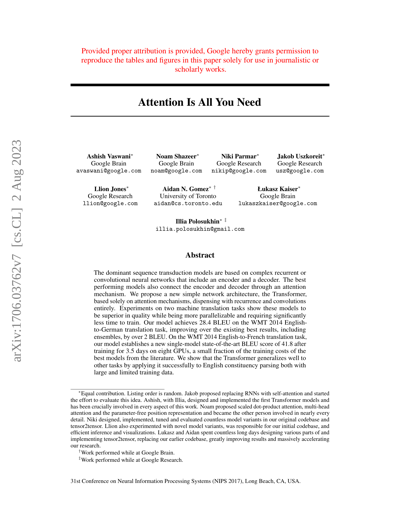

In [6]:
print("Converting PDF to images...")
images = convert_from_path(pdf_path, dpi=200)

print(f"✅ Converted {len(images)} pages to images")
print(f"   Image size: {images[0].size}")

# Display first page
print("\nPreview of first page:")
display(images[0].resize((400, int(400 * images[0].height / images[0].width))))

## 6. Encode Document Pages

ColNetraEmbed creates multi-vector embeddings for each page, capturing fine-grained visual and textual details.

In [8]:
# Process in batches to avoid memory issues
batch_size = 2  # Process 2 pages at a time

print(f"Encoding {len(images)} pages with ColNetraEmbed...")
print(f"Processing in batches of {batch_size} to save memory\n")

# Process images in batches
image_embeddings_list = []

for i in range(0, len(images), batch_size):
    batch = images[i : i + batch_size]
    print(
        f"Processing batch {i//batch_size + 1}/{(len(images) + batch_size - 1)//batch_size}: pages {i+1}-{min(i+batch_size, len(images))}"
    )

    # Process batch
    batch_images = processor.process_images(batch).to(device)

    # Generate embeddings
    with torch.no_grad():
        batch_embeddings = model(**batch_images)

    image_embeddings_list.append(batch_embeddings.cpu())

    # Clear GPU memory after each batch
    del batch_images, batch_embeddings
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Concatenate all embeddings
image_embeddings = torch.cat(image_embeddings_list, dim=0).to(device)

print("\n✅ Images encoded successfully!")
print(f"   - Embedding shape: {image_embeddings.shape}")
print(f"   - Dtype: {image_embeddings.dtype}")
print("   - Shape format: (num_images, num_tokens, embedding_dim)")
print(f"   - Each page has {image_embeddings.shape[1]} token embeddings")

Encoding 15 pages with ColGemma3...
Processing in batches of 2 to save memory

Processing batch 1/8: pages 1-2
Processing batch 2/8: pages 3-4
Processing batch 3/8: pages 5-6
Processing batch 4/8: pages 7-8
Processing batch 5/8: pages 9-10
Processing batch 6/8: pages 11-12
Processing batch 7/8: pages 13-14
Processing batch 8/8: pages 15-15

✅ Images encoded successfully!
   - Embedding shape: torch.Size([15, 269, 128])
   - Dtype: torch.bfloat16
   - Shape format: (num_images, num_tokens, embedding_dim)
   - Each page has 269 token embeddings


## 7. Query the Document

Let's search for specific content in the document!

In [9]:
# Define your query
query = "multi-head attention mechanism"

print(f"Query: '{query}'\n")

# Encode query
batch_query = processor.process_queries([query]).to(device)

with torch.no_grad():
    query_embedding = model(**batch_query)

print("✅ Query encoded!")
print(f"   - Query embedding shape: {query_embedding.shape}")
print(f"   - Query has {query_embedding.shape[1]} token embeddings")

Query: 'multi-head attention mechanism'

✅ Query encoded!
   - Query embedding shape: torch.Size([1, 14, 128])
   - Query has 14 token embeddings


## 8. Compute MaxSim Scores and Retrieve Top Pages

ColNetraEmbed uses MaxSim (maximum similarity) scoring for late interaction between query and document tokens.

In [14]:
# Compute MaxSim scores
scores = processor.score_multi_vector(
    qs=query_embedding,
    ps=image_embeddings,
)

print(f"MaxSim scores shape: {scores.shape}")
print(f"Scores: {scores[0].tolist()}\n")

# Get top 3 results
top_k = 2
top_indices = scores[0].argsort(descending=True)[:top_k]

print(f"\n🔍 Top {top_k} Results for query: '{query}'\n")
print("=" * 60)

for rank, idx in enumerate(top_indices, 1):
    score = scores[0, idx].item()
    print(f"Rank {rank}: Page {idx.item() + 1} - MaxSim Score: {score:.2f}")

print("=" * 60)

MaxSim scores shape: torch.Size([1, 15])
Scores: [10.9375, 10.5625, 11.0, 11.25, 11.25, 10.1875, 10.4375, 8.5625, 10.25, 9.875, 9.4375, 9.1875, 10.9375, 10.3125, 10.625]


🔍 Top 2 Results for query: 'multi-head attention mechanism'

Rank 1: Page 4 - MaxSim Score: 11.25
Rank 2: Page 5 - MaxSim Score: 11.25


## 9. Generate Attention Heatmaps

ColNetraEmbed's multi-vector embeddings enable visualization of which parts of the page are most relevant to the query.

In [15]:
def generate_heatmap(
    image: Image.Image,
    query_embedding: torch.Tensor,
    image_embedding: torch.Tensor,
) -> Image.Image:
    """Generate attention heatmap overlay for a page."""
    try:
        # Get image mask and patches
        batch_images_single = processor.process_images([image]).to(device)

        if "input_ids" in batch_images_single and hasattr(model.config, "image_token_id"):
            image_token_id = model.config.image_token_id
            image_mask = batch_images_single["input_ids"] == image_token_id
        else:
            image_mask = torch.ones(
                image_embedding.shape[0], image_embedding.shape[1],
                dtype=torch.bool, device=device
            )

        # Calculate patch grid dimensions
        num_image_tokens = image_mask.sum().item()
        n_side = int(math.sqrt(num_image_tokens))

        if n_side * n_side == num_image_tokens:
            n_patches = (n_side, n_side)
        else:
            n_patches = (16, 16)  # fallback

        # Get similarity maps
        similarity_maps_list = get_similarity_maps_from_embeddings(
            image_embeddings=image_embedding,
            query_embeddings=query_embedding,
            n_patches=n_patches,
            image_mask=image_mask,
        )

        similarity_map = similarity_maps_list[0]

        # Convert to float if needed
        if similarity_map.dtype == torch.bfloat16:
            similarity_map = similarity_map.float()

        # Aggregate across query tokens (mean)
        aggregated_map = torch.mean(similarity_map, dim=0)

        # Prepare image and similarity map
        img_array = np.array(image.convert("RGBA"))
        similarity_map_array = normalize_similarity_map(aggregated_map).to(torch.float32).cpu().numpy()
        similarity_map_array = rearrange(similarity_map_array, "h w -> w h")

        # Resize similarity map to match image
        similarity_map_image = Image.fromarray(
            (similarity_map_array * 255).astype("uint8")
        ).resize(image.size, Image.Resampling.BICUBIC)

        # Create heatmap overlay
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img_array)
        ax.imshow(
            similarity_map_image,
            cmap=sns.color_palette("mako", as_cmap=True),
            alpha=0.5,
        )
        ax.set_axis_off()
        plt.tight_layout()

        # Convert to PIL Image
        buffer = io.BytesIO()
        plt.savefig(buffer, format="png", dpi=150, bbox_inches="tight", pad_inches=0)
        buffer.seek(0)
        heatmap_image = Image.open(buffer).copy()
        plt.close()

        return heatmap_image

    except Exception as e:
        print(f"❌ Heatmap generation error: {str(e)}")
        return image

print("✅ Heatmap function defined!")

✅ Heatmap function defined!


## 10. Visualize Top Results with Heatmaps


🔍 Top 2 Retrieved Pages with Attention Heatmaps
Query: 'multi-head attention mechanism'


──────────────────────────────────────────────────────────────────────
📄 Rank 1: Page 4 - MaxSim Score: 11.25
──────────────────────────────────────────────────────────────────────
Generating heatmap...


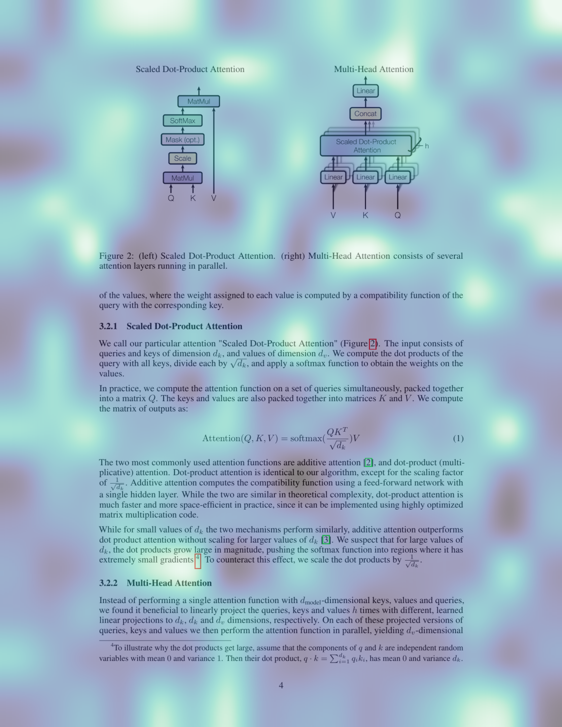


──────────────────────────────────────────────────────────────────────
📄 Rank 2: Page 5 - MaxSim Score: 11.25
──────────────────────────────────────────────────────────────────────
Generating heatmap...


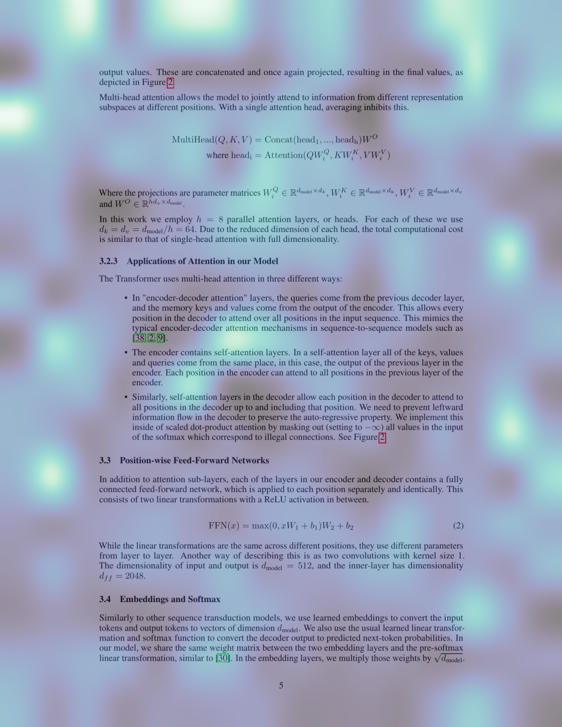


✅ Heatmaps generated! Brighter areas = Higher attention to query


In [16]:
from IPython.display import display

print(f"\n{'='*70}")
print(f"🔍 Top {top_k} Retrieved Pages with Attention Heatmaps")
print(f"Query: '{query}'")
print(f"{'='*70}\n")

for i, idx in enumerate(top_indices):
    score = scores[0, idx].item()
    page_num = idx.item() + 1

    print(f"\n{'─'*70}")
    print(f"📄 Rank {i+1}: Page {page_num} - MaxSim Score: {score:.2f}")
    print(f"{'─'*70}")
    print("Generating heatmap...")

    # Generate heatmap
    heatmap_image = generate_heatmap(
        image=images[idx.item()],
        query_embedding=query_embedding,
        image_embedding=image_embeddings[idx.item()].unsqueeze(0),
    )

    # Display at half width
    new_width = heatmap_image.width // 2
    new_height = heatmap_image.height // 2
    display(heatmap_image.resize((new_width, new_height)))

print(f"\n{'='*70}")
print("✅ Heatmaps generated! Brighter areas = Higher attention to query")
print(f"{'='*70}")

## 11. Try Your Own Queries!

Modify the query below and run to search for different content:


🔍 Searching for: 'positional encoding'

──────────────────────────────────────────────────────────────────────
📄 Rank 1: Page 6 - MaxSim Score: 9.44
──────────────────────────────────────────────────────────────────────
Generating heatmap...


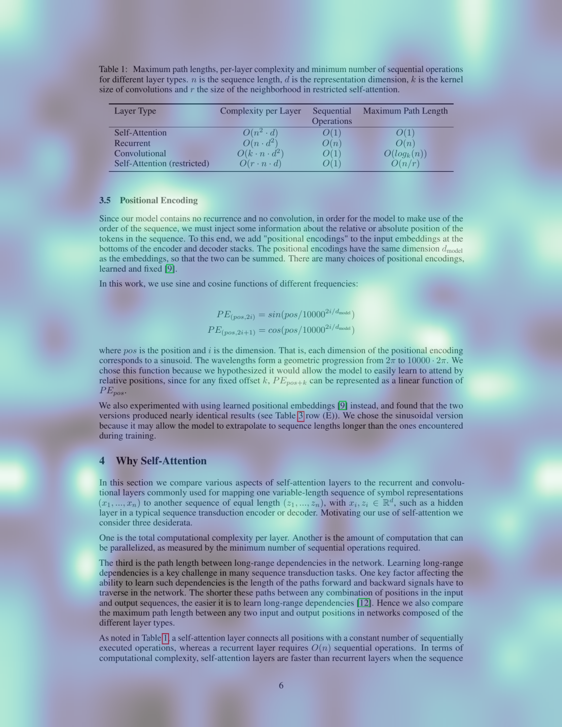


──────────────────────────────────────────────────────────────────────
📄 Rank 2: Page 3 - MaxSim Score: 9.25
──────────────────────────────────────────────────────────────────────
Generating heatmap...


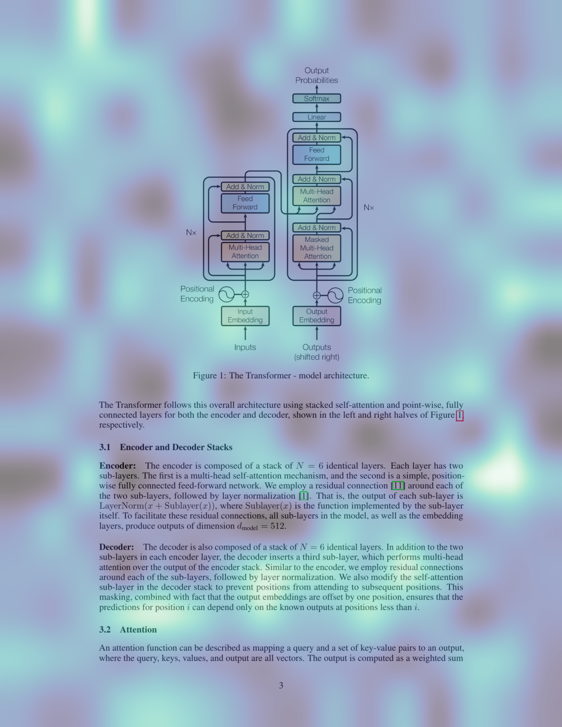


──────────────────────────────────────────────────────────────────────
📄 Rank 3: Page 5 - MaxSim Score: 9.19
──────────────────────────────────────────────────────────────────────
Generating heatmap...


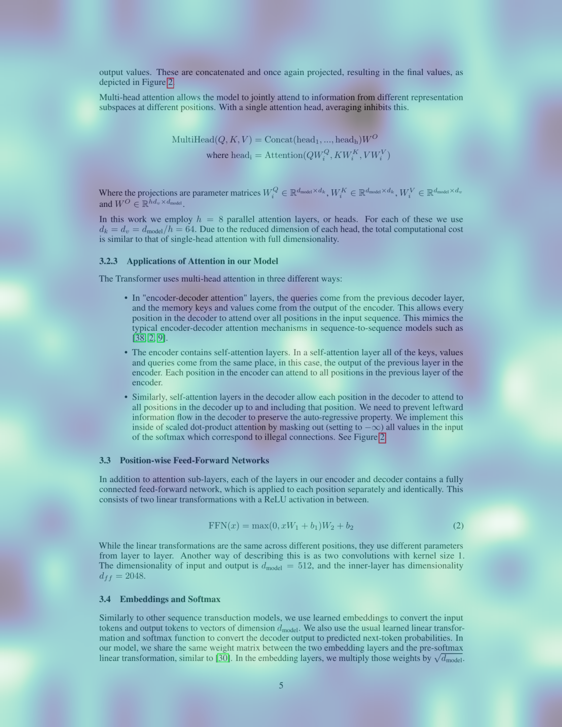

In [17]:
from IPython.display import display

def search_document_with_heatmaps(query_text, top_k=3, show_heatmaps=True):
    """Search the document with a custom query and optionally show heatmaps."""
    print(f"\n{'='*70}")
    print(f"🔍 Searching for: '{query_text}'")
    print(f"{'='*70}")

    # Encode query
    batch_query = processor.process_queries([query_text]).to(device)
    with torch.no_grad():
        query_emb = model(**batch_query)

    # Compute scores
    scores = processor.score_multi_vector(qs=query_emb, ps=image_embeddings)
    top_indices = scores[0].argsort(descending=True)[:top_k]

    # Display results
    for rank, idx in enumerate(top_indices, 1):
        score = scores[0, idx].item()
        page_num = idx.item() + 1

        print(f"\n{'─'*70}")
        print(f"📄 Rank {rank}: Page {page_num} - MaxSim Score: {score:.2f}")
        print(f"{'─'*70}")

        if show_heatmaps:
            print("Generating heatmap...")
            img = generate_heatmap(
                image=images[idx.item()],
                query_embedding=query_emb,
                image_embedding=image_embeddings[idx.item()].unsqueeze(0),
            )
        else:
            img = images[idx.item()]

        # Display at half width
        new_width = img.width // 2
        new_height = img.height // 2
        display(img.resize((new_width, new_height)))

# Try different queries:
search_document_with_heatmaps("positional encoding", top_k=3, show_heatmaps=True)

## Summary

**Key Features of ColNetraEmbed:**
- ✅ Multi-vector embeddings for fine-grained retrieval
- ✅ Late interaction with MaxSim scoring
- ✅ Interpretable attention heatmaps
- ✅ Superior quality for complex document understanding

**Understanding Heatmaps:**
- Brighter areas = Higher attention/relevance to the query
- Shows which parts of the page match the query
- Helps explain retrieval decisions

**Next Steps:**
- Try with your own PDFs
- Experiment with complex queries
- Test multilingual documents
- Compare with NetraEmbed (BiGemma3) for speed vs quality tradeoffs

**Learn More:**
- [Full Documentation](https://github.com/adithya-s-k/colpali)
- [Paper](https://arxiv.org/abs/2512.03514)
- [Model Card](https://huggingface.co/Cognitive-Lab/ColNetraEmbed)